In [1]:
#Import important library 
import numpy as np
import sys
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
sys.path.append('.')


# Internal inmport

from src.models.GraphModelclass import *
from src.models.mGGclass import *

from src.utils.AuxiliaryFunc import *
from src.utils.CootoNetworkX import *

from src.inference.GraphMCMCclass import * 
from src.inference.Graphmcmcsamples import *

from src.sampling.CaronFoxGraph_rnd import CRMtoGraph
from src.sampling.mGG_size_biased_rnd import mGG_size_biased_sampling

from src.display.plotposteriorpredictivedegreedistrib import plot_posterior_predictive_degree
from src.display.plot_mean_w_ci import plot_mean_w_ci

In this notebook we demonstrate how to use our methods on synthetic data. The notebook is divided into two parts:
1) Sampling and analysis of a network using the Caron-Fox model with the mGG Lévy measure 
2) Inference on the parameters on the generated graph using our MCMC algorithms

# Sampling of a graph from mGG

We choose some parameters and generate a mGG CRM, than we sample a network from it

In [2]:
# Hyperparameters of the model
alpha = 1.0
tau = 0.0
beta_true = 1.0
c_true = 2.0
eta_true = 50.0

# Hyperparameters of the simulation
N_weight = 10**6 # Number of weights

In [3]:
## CRM sampling using Size biased sampling
PPP = mGG(alpha=alpha, tau=tau, beta=beta_true, c=c_true, eta=eta_true)
w_CRM, missing_mass, S = mGG_size_biased_sampling(alpha, tau, beta_true, c_true, eta_true, N_weight)

In [4]:
## CRM plot
threshold=1e-4

mask=w_CRM>threshold
lenmask=np.sum(mask)
random_numbers = np.random.rand(lenmask)


plt.figure(figsize=(8, 4))
plt.stem(random_numbers,w_CRM[mask],markerfmt='',basefmt='')
plt.title('Plot of the CRM aproximate by size biased sampling')
plt.xlabel('Theta')
plt.ylabel('$W_i$')
plt.show()

In [5]:
# Graph sampling from the CRM using the Caron-Fox method
G, wtrue, wtrue_rem, G_multi, ind_w = CRMtoGraph(w_CRM,missing_mass,store=True)
K = G.shape[0]
Strue = np.ones(len(wtrue))
Strue[:len(ind_w)] = S[ind_w]


In [6]:
# Graph description 
print('Nb of nodes:', K)
print('Nb of edges:', int(np.sum(G)/2))
print('Nb of multiedges:', int(np.sum(G_multi)))

deg_multi = np.sum(G_multi,axis=1)[:len(wtrue)] + np.sum(G_multi,axis=0)[:len(wtrue)].T
N = np.array(deg_multi).squeeze() # multigraph degrees



Nb of nodes: 2194
Nb of edges: 2895
Nb of multiedges: 3483


In [7]:
#Graph plot
# Node positions using spring layout
Gnx = coo_to_networkx(G)
pos = nx.random_layout(Gnx, seed=42)

# Node degrees for size scaling
degrees = np.array([Gnx.degree(n) for n in Gnx.nodes()])
node_sizes = 1+4*degrees  # Scale node size by degree

# Colour nodes based on degree
# Colour nodes: darker for higher degree
# Colour nodes: darker shades of blue for higher degree
cmap = plt.colormaps["Blues"]
norm = mcolors.Normalize(vmin=1, vmax=100)
node_colors = [cmap(0.5+0.7*norm(deg)) for deg in degrees]


# Draw the graph
plt.figure(figsize=(6, 6))
nx.draw_networkx_nodes(Gnx, pos, node_size=node_sizes,node_color=node_colors, alpha=0.8)
# Draw curved edges
for edge in Gnx.edges():
    node1, node2 = edge
    rad = 0.2  # Controls the curvature
    edge_patch = mpatches.FancyArrowPatch(
        pos[node1], pos[node2],
        connectionstyle=f"arc3,rad={rad}",
        color="black", alpha=0.1, lw=0.1
    )
    plt.gca().add_patch(edge_patch)
# Show the plot
plt.axis("off")
plt.show()

# Posterior inference on the synthetic data

Now we perform inference of a mGG graph on the generated data 

In [8]:
# Choose prior
alpha=1
tau=0.
hyper_beta = [0.01, 0.01]  # Improper prior on beta
hyper_c = [20, 0.5] 
hyper_eta = [0.1, 0.1] # Improper prior on eta
objprior = GraphModel('Rapid',alpha,tau, hyper_beta, hyper_c, hyper_eta)


# Parametter of the  MCMC Algorithm
niter = 100000
nburn = 0
nadapt = niter//2
thin = niter//1000
nchains = 2

objmcmc = GraphMCMC(objprior, niter, nburn, thin, nadapt, nchains, store_w=True)
objmcmc.settings["hyper"]={'rw_std': np.array([0.01,0.01,0.02]), 'MH_nb': 1}

optional_arg = defaultdict(lambda: None)
optional_arg["decoupling"]=True
optional_arg['nmass']=100

true_value = defaultdict(lambda: None)


In [9]:
graphmcmcsamples(objmcmc,G,optional_arg,true_value,output_dir="output_dir",verbose=False)

[os.remove(f"{d}/{f}") for d, _, fs in os.walk("output_dir", False) for f in fs]
[os.rmdir(d) for d, ds, _ in os.walk("output_dir", False)]


100%|██████████| 100000/100000 [01:30<00:00, 1100.13it/s]


-------------------------------
End MCMC for mGG graphs
-------------------------------


100%|██████████| 100000/100000 [01:29<00:00, 1122.34it/s]


-------------------------------
End MCMC for mGG graphs
-------------------------------


[None, None]

# Visualisation of the inference procedure


We then display the trace plots, credibility intervals and posterior predictive of the degree distribution.

## Trace plots of the hyperparameters  

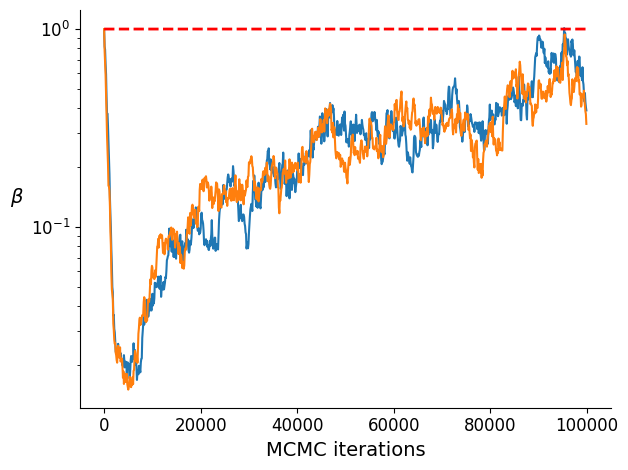

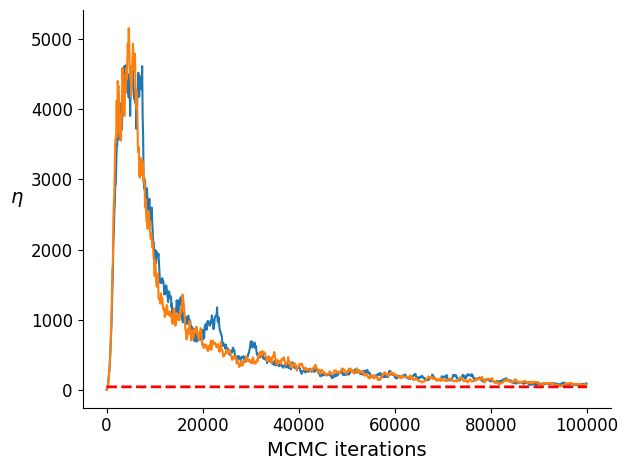

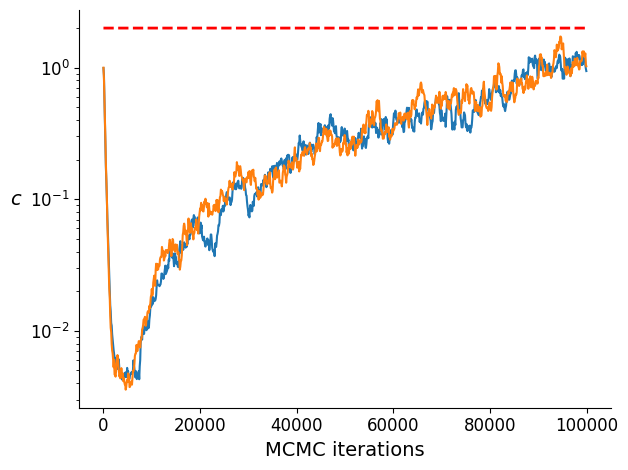

In [ ]:
X=np.arange(0,niter,thin)

plt.figure(dpi=100)
for i in range(nchains):
    plt.plot(X, objmcmc.samples[i]["beta"])
plt.plot([beta_true] * niter, 'r--', linewidth=2)
plt.yscale('log')
plt.ylabel(r'$\beta$', fontsize=14, rotation=0, labelpad=10)
plt.xlabel('MCMC iterations', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.show()


plt.figure(dpi=100)
for i in range(nchains):
    plt.plot(X, objmcmc.samples[i]["eta"])
plt.plot([eta_true] * niter, 'r--', linewidth=2)
plt.ylabel(r'$\eta$', fontsize=14, rotation=0, labelpad=10)
plt.xlabel('MCMC iterations', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.show()

plt.figure(dpi=100)
for i in range(nchains):
    plt.plot(X, objmcmc.samples[i]["c"])
plt.plot([c_true] * niter, 'r--', linewidth=2)
plt.yscale('log')
plt.ylabel(r'$c$', fontsize=14, rotation=0, labelpad=10)
plt.xlabel('MCMC iterations', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.show()


plt.figure(dpi=100)
for i in range(nchains):
    plt.plot(X, objmcmc.samples[i]["w_rem"])
plt.plot([wtrue_rem] * niter, 'r--', linewidth=2)
plt.ylabel(r'w_rem', fontsize=14, rotation=90, labelpad=10)
plt.xlabel('MCMC iterations', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.show()

plt.figure(dpi=100)
for i in range(nchains):
    plt.plot(X,np.sum(objmcmc.samples[i]["w"], axis=1))
plt.plot([np.sum(wtrue)]*niter, 'r--', linewidth=2)
plt.ylabel(r'sum_w', fontsize=14, rotation=90, labelpad=10)
plt.xlabel('MCMC iterations', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(0, 2*np.sum(wtrue))
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.show()

## Trace plots of some weights

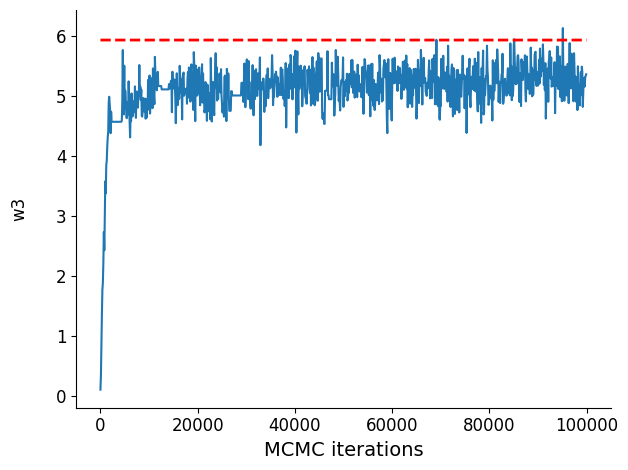

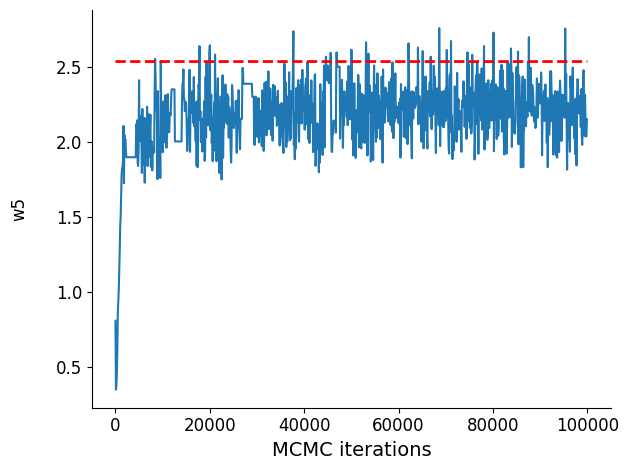

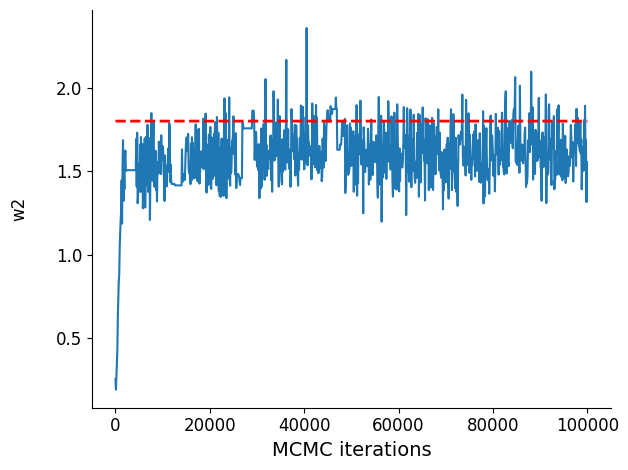

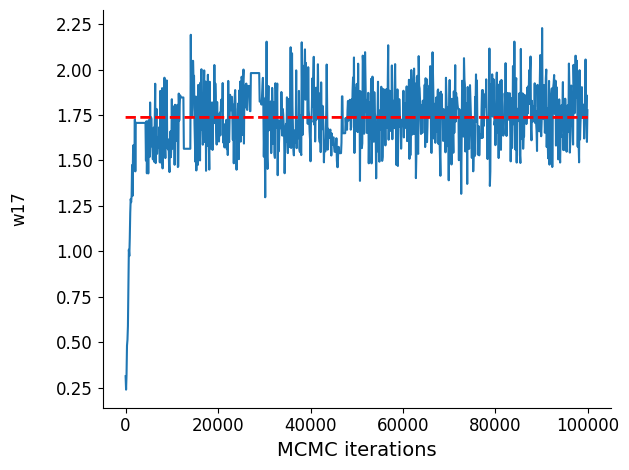

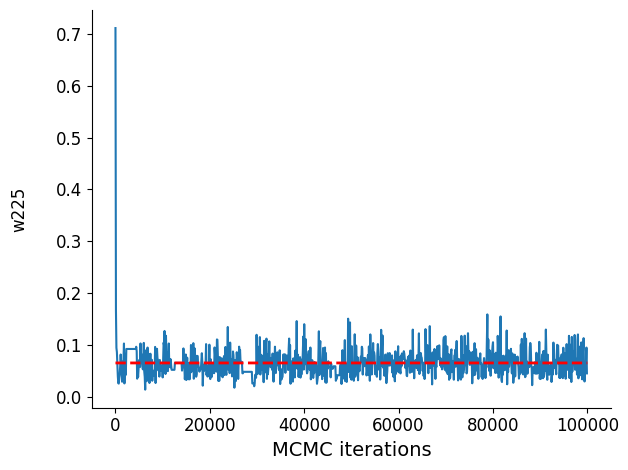

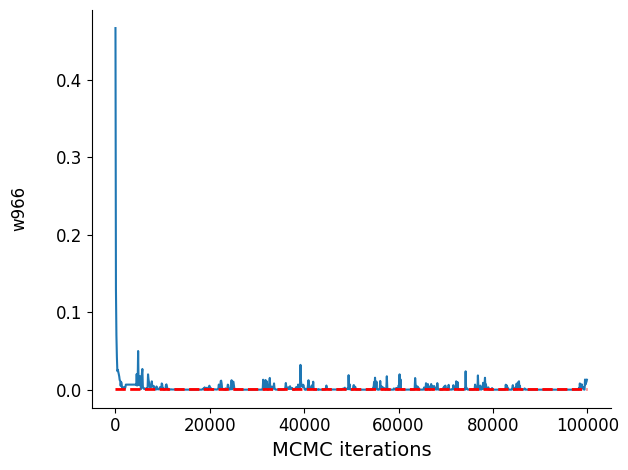

In [ ]:
#We order th weights by degree
ind= np.array(np.argsort(np.sum(G, axis=0)))
ind=ind[0][::-1]


niter
# Plot largest weights
ind = np.argsort(wtrue)[::-1]
for i in range(4):
    plt.figure(dpi=100)
    for j in range(nchains):
        plt.plot(X, objmcmc.samples[j]["w"][:, ind[i]])
    plt.plot(wtrue[ind[i]]*np.ones(niter), 'r--', linewidth=2)
    plt.ylabel(f'w{str(ind[i])}', fontsize=12, rotation=90, labelpad=20)
    plt.xlabel('MCMC iterations', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.tight_layout()
    plt.show()
    
# Plot some small weights
ind2 = [100, 500, 1000]
for i in ind2:
    if K>i:
        plt.figure(dpi=100)
        for j in range(nchains):
            plt.plot(X, objmcmc.samples[j]["w"][:, ind[i]])
        plt.plot(wtrue[ind[i]]*np.ones(niter), 'r--', linewidth=2)
        plt.ylabel(f'w{str(ind[i])}', fontsize=12, rotation=90, labelpad=20)
        plt.xlabel('MCMC iterations', fontsize=14)
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        ax = plt.gca()
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        plt.tight_layout()
        plt.show()

## Credible intervals on the weights 

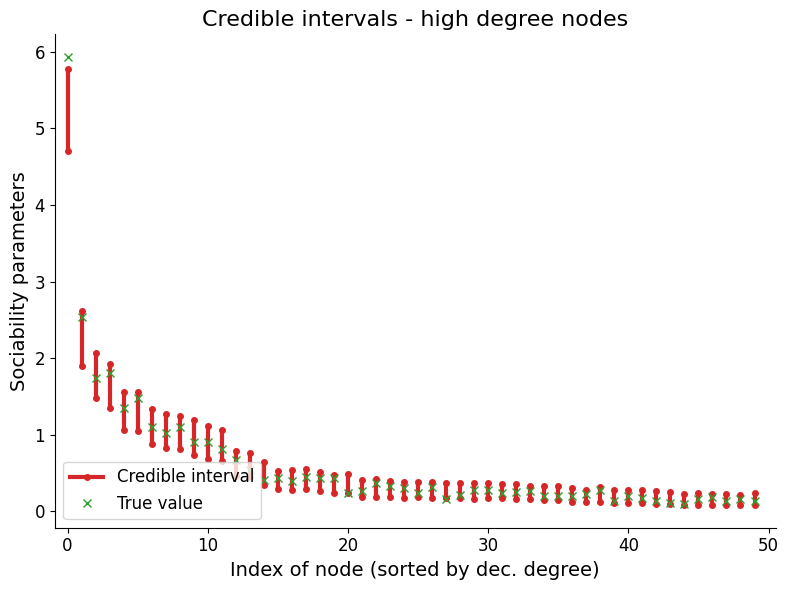

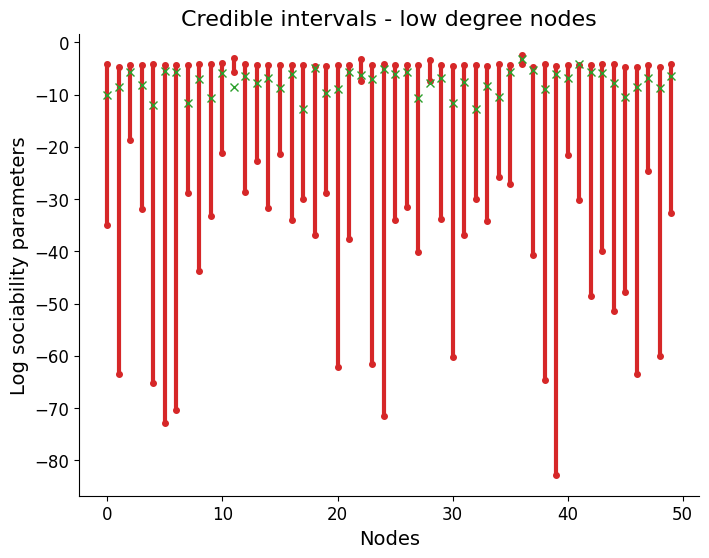

In [18]:
nburn = niter//2//thin
plot_mean_w_ci(G, objmcmc, wtrue,nburn,dpi=100)

## Posterior predictive degree distribution

Rapid


  2%|▏         | 4/200 [00:00<00:05, 34.09it/s]

Sample 0/200 from the posterior predictive


100%|██████████| 200/200 [00:04<00:00, 41.76it/s]
/Users/vkilian/TheseShareFile/rapidly_varying_crm/code/src/display/plotposteriorpredictivedegreedistrib.py:122: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax.set_xlim(xlim)


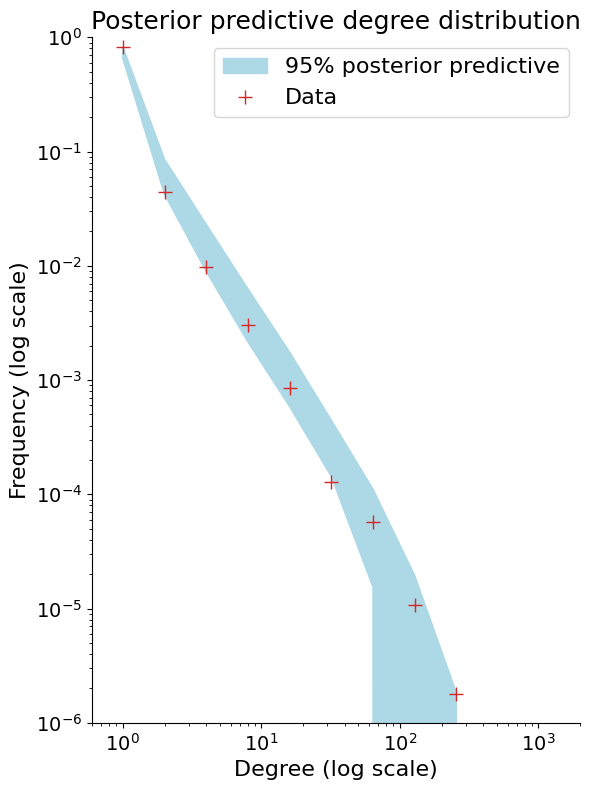

In [ ]:
plot_posterior_predictive_degree(objmcmc,nburn=nburn,niter=niter,thin=thin,G=G,ndraws=100,dpi=100,ylim=(10**(-6), 1))